# Finite Element Solution to the 1D Poisson Equation

In the following, we will solve the Poisson equation subject to Dirichlet boundary conditions, i.e.

\begin{equation}
    \begin{cases}
        -\Delta u = f & \text{in } \operatorname{int} \Omega \\
        u = g         & \text{on } \partial \Omega
    \end{cases}
\end{equation}

Here, we set $\Omega = [a, b] \subset \mathbb{R}$, which means that the problem reduces to

\begin{equation}
    \begin{cases}
        -u''(x) = f(x) & \text{for } x \in (a, b) \\
        u(x) = g(x) & \text{for } x \in \{a, b\} \\
    \end{cases}
\end{equation}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import probnum as pn
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

In [2]:
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

In [3]:
N = 11

In [4]:
grid = np.linspace(-1, 1, N)

## 1D Tent Basis Functions

In [5]:
def plot_1d_tent_functions(grid, values=None):
    """Assumes an ordered grid"""
    if values is None:
        values = np.ones_like(grid)

    # Left boundary value
    plt.plot([grid[0], grid[1]], [values[0], 0])
    
    xs = np.vstack((grid[:-2], grid[1:-1], grid[2:]))

    ys = np.empty_like(xs)
    ys[0, :] = 0.0
    ys[1, :] = values[1:-1]
    ys[2, :] = 0.0

    plt.plot(xs, ys)
    
    # Right boundary value
    plt.plot([grid[-2], grid[-1]], [0, values[-1]])

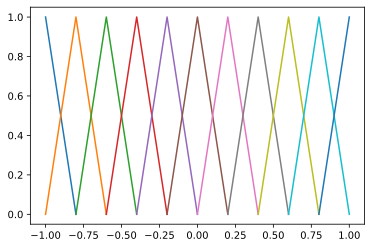

In [6]:
plot_1d_tent_functions(grid)

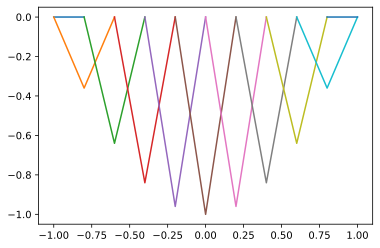

In [7]:
plot_1d_tent_functions(grid, values=grid ** 2 - 1)

## Approximation of the Laplace Operator on the Grid

In [8]:
def discrete_1d_laplace_operator(grid):
    # Diagonal
    diag = 1 / (grid[1:-1] - grid[:-2])
    diag += 1 / (grid[2:] - grid[1:-1])

    # Off-Diagonals
    offdiag = -1.0 / (grid[2:-1] - grid[1:-2])
    
    return pn.linops.Matrix(
        scipy.sparse.diags(
            (offdiag, diag, offdiag),
            offsets=(-1, 0, 1),
            format="csr",
            dtype=np.double,
        )
    )

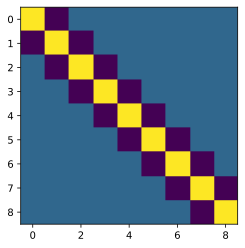

In [9]:
plt.imshow(discrete_1d_laplace_operator(grid).todense())
plt.show()

## Approximation of the RHS on the Grid

In [10]:
def discrete_1d_laplace_rhs(grid, alpha):
    return (alpha / 2) * (grid[2:] - grid[:-2])

In [11]:
discrete_1d_laplace_rhs(grid, 1.0)

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

## Solution

In [12]:
def discrete_1d_laplace_solve(grid):
    A = discrete_1d_laplace_operator(grid)
    b = discrete_1d_laplace_rhs(grid, 2.0)

    (u, _) = scipy.sparse.linalg.cg(-A.A, b)
    
    sol = np.empty_like(u, shape=(u.size + 2,))
    
    sol[0] = 0.0
    sol[1:-1] = u
    sol[-1] = 0.0
    
    return sol

In [13]:
sol = discrete_1d_laplace_solve(grid)

In [14]:
sol

array([ 0.  , -0.36, -0.64, -0.84, -0.96, -1.  , -0.96, -0.84, -0.64,
       -0.36,  0.  ])

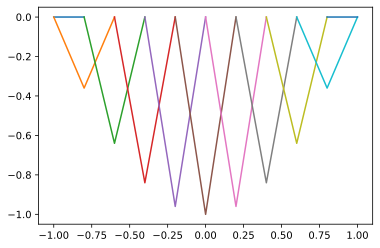

In [15]:
plot_1d_tent_functions(grid, values=sol)

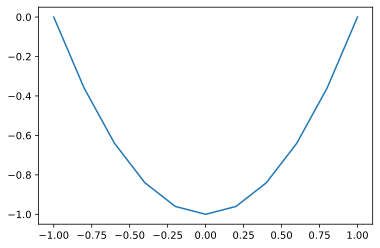

In [16]:
plt.plot(grid, sol)

## 1D Poisson Problem FEM with Boundary Conditions in System

In [ ]:
def discrete_poisson_problem_with_boundary_conditions(grid):
    (N,) = grid.shape
    
    diag = np.empty_like(grid)
    offdiag = np.empty_like(grid, shape=(N - 1,))

    # Laplace Operator on the interior
    diag[1:-1] = (  
        1 / (grid[1:-1] - grid[:-2])
        + 1 / (grid[2:] - grid[1:-1])
    )
    offdiag[1:-1] = -1.0 / (grid[2:-1] - grid[1:-2])
    
    # Left boundary condition
    diag[0] = 1.0
    offdiag[0] = 0.0
    
    # Right boundary condition
    diag[-1] = 1.0
    offdiag[-1] = 0.0
    
    return pn.linops.Matrix(
        scipy.sparse.diags(
            (offdiag, diag, offdiag),
            offsets=(-1, 0, 1),
            format="csr",
            dtype=grid.dtype,
        )
    )

In [ ]:
plt.imshow(discrete_poisson_problem_with_boundary_conditions(grid).todense())
plt.colorbar()

## 1D Fourier Basis Functions

In [17]:
def fourier_basis_element_1d(x, n, domain=(-1.0, 1.0)):
    return np.sin(n * np.pi * (x - domain[0]) / (domain[1] - domain[0]))

In [18]:
def plot_1d_fourier_basis_functions(n_funcs: int, domain=(-1.0, 1.0)):
    grid = np.linspace(domain[0], domain[1], 100)
    
    for n in range(1, n_funcs + 1):
        plt.plot(grid, fourier_basis_element_1d(grid, n, domain))

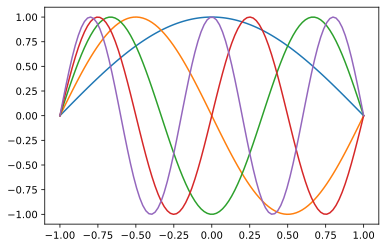

In [19]:
plot_1d_fourier_basis_functions(5)

In [20]:
def coeffs_to_solution(coeffs, domain=(-1.0, 1.0)):
    ns = np.arange(1, coeffs.size + 1)

    def _sol(grid):
        sol = fourier_basis_element_1d(  # shape: (G, N)
            grid[:, None],
            ns[None, :],
            domain,
        )
        sol *= coeffs
        
        return np.sum(sol, axis=-1)
    
    return _sol

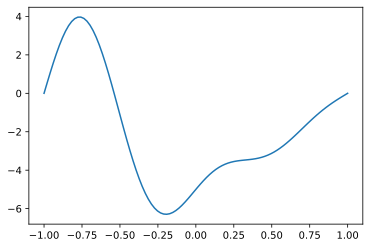

In [21]:
grid = np.linspace(-1.0, 1.0, 100)

plt.plot(
    grid,
    coeffs_to_solution(np.array([-4.0, 1.0, 2.0, 2.0, 1.0]))(grid)
)

## Approximate Laplace Operator in the Fourier Basis

In [22]:
def discrete_1d_fourier_laplace(N: int, domain=(-1.0, 1.0)):
    a, b = domain
    Ns = np.arange(1, N + 1)

    return pn.linops.Matrix(
        scipy.sparse.diags(
            Ns * np.pi / (4 * (b - a)) * ((2 * np.pi) * Ns + np.sin((2 * np.pi) * Ns)),
            offsets=0,
            format="csr",
            dtype=np.double,
        )
    )

In [23]:
discrete_1d_fourier_laplace(6)

<Matrix with shape=(6, 6) and dtype=float64>

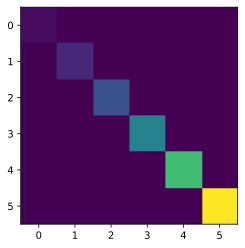

In [24]:
plt.imshow(discrete_1d_fourier_laplace(6).todense())
plt.show()

## Approximate RHS in the Fourier Basis

In [25]:
def discrete_1d_fourier_rhs(alpha, N: int, domain=(-1.0, 1.0)):
    a, b = domain
    Ns = np.arange(1, N + 1)

    return alpha * (b - a) / np.pi * (1 - np.cos(np.pi * Ns)) / Ns

In [26]:
discrete_1d_fourier_rhs(1.0, 6)

array([1.27323954, 0.        , 0.42441318, 0.        , 0.25464791,
       0.        ])

## Solution

In [27]:
def discrete_1d_fourier_solve(N: int, domain=(-1.0, 1.0)):
    A = discrete_1d_fourier_laplace(N, domain)
    b = discrete_1d_fourier_rhs(2.0, N, domain)

    (coeffs, _) = scipy.sparse.linalg.cg(-A.A, b)
    
    return coeffs

In [28]:
coeffs = discrete_1d_fourier_solve(N=3)
sol = coeffs_to_solution(coeffs)

In [29]:
coeffs

array([-1.0320491 ,  0.        , -0.03822404])

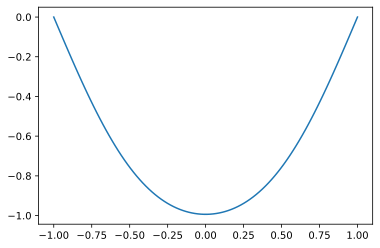

In [30]:
grid = np.linspace(-1.0, 1.0, 100)

plt.plot(grid, sol(grid))

# Probabilistic Numerical Solution of the Linear System
\begin{equation}
    \renewcommand{\vec}[1]{\mathbf{#1}}
    \newcommand{\inprod}[2]{\left\langle #1, #2 \right\rangle}
    \newcommand{\norm}[1]{\left\lVert #1 \right\rVert}
\end{equation}

We now solve the linear system $A x = b$ using a solution-based probabilistic linear solver.
This essentially boils down to online inference in a linear Gaussian model.
We assume that we have a prior $$p(x) = \mathcal{N}(x; \mu_0, \Sigma_0)$$ over the solution of the linear system.
In each iteration of the solver, we collect information about the solution by projecting onto a one dimensional subspace defined by $s_i$: $$y_i := s_i^T b = (s_i^T A) x.$$
Let $S_m := \begin{pmatrix} s_1, \dots, s_m \end{pmatrix}$ and $\vec{y}_m := \begin{pmatrix} y_1, \dots, y_m \end{pmatrix}^T$.
We can now infer $x$ using the Dirac likelihood $$p(y \mid x) = \delta(\vec{y}_m - S_m^T A x).$$
Since this is an observation of a linear function of $x$, we can perform inference in closed form.
The posterior for step $m$ is then given by $$p(x \mid y) = \mathcal{N}(x; \mu_m, \Sigma_m),$$ with
\begin{align}
    \mu_m & := \mu_0 + \Sigma_0 A^T S_m \Lambda_m^{-1} S_m^T r_0 \\
    \Sigma_m & := \Sigma_0 - \Sigma_0 A^T S_m \Lambda_m^{-1} S_m^T A \Sigma_0,
\end{align}
where $r_0 := b - A \mu_0$ is the initial residual and $\Lambda_m := S_m^T A \Sigma_0 A^T S_m$.

To keep inference tractable, we must choose $S_m$ such that $\Lambda_m$ is diagonal.
This can be achieved by considering $A \Sigma_0 A^T$-orthonormal search directions, i.e. $\inprod{s_i}{s_j}_{A \Sigma_0 A^T} = \delta_{ij}$. In this case, we have $(\Lambda_m)_{i,j} = \delta_{ij}$ and thus
\begin{align}
    \mu_m
    & = \mu_0 + \Sigma_0 A^T S_m S_m^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T \sum_{i = 1}^m s_i s_i^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T \sum_{i = 1}^{m - 1} s_i s_i^T r_0 + \Sigma_0 A^T s_m s_m^T r_0 \\
    & = \mu_0 + \Sigma_0 A^T S_{m - 1} S_{m - 1}^T r_0 + \Sigma_0 A^T s_m (s_m^T b - s_m^T A \mu_0) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m (s_m^T b - s_m^T A \mu_0 - \underbrace{s_m^T A \Sigma_0 A^T S_{m - 1}}_{= 0} S_{m - 1}^T r_0) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m s_m^T (b - A (\mu_0 + \Sigma_0 A^T S_{m - 1} S_{m - 1}^T r_0)) \\
    & = \mu_{m - 1} + \Sigma_0 A^T s_m s_m^T \underbrace{(b - A \mu_{m - 1})}_{=: r_{m - 1}}
\end{align}

and

\begin{align}
    \Sigma_m
    & = \Sigma_0 - \Sigma_0 A^T S_m S_m^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T \sum_{i = 1}^m s_i s_i^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T \sum_{i = 1}^{m - 1} s_i s_i^T A \Sigma_0 - \Sigma_0 A^T s_i s_i^T A \Sigma_0 \\
    & = \Sigma_0 - \Sigma_0 A^T S_{m - 1} S_{m - 1}^T A \Sigma_0 - \Sigma_0 A^T s_i (\Sigma_0 A^T s_i)^T \\
    & = \Sigma_{m - 1} - \Sigma_0 A^T s_i (\Sigma_0 A^T s_i)^T.
\end{align}

We can generate $A \Sigma_0 A^T$-orthonormal search directions $s_m$ on-the-fly as in CG, i.e. $s_m = \frac{\tilde{s}_m}{\norm{\tilde{s}_m}_{A \Sigma_0 A^T}}$, $\tilde{s}_1 = r_0$ and

\begin{align}
    \tilde{s}_m = r_{m - 1} - \inprod{s_{m - 1}}{r_{m - 1}}_{A \Sigma_0 A^T} s_{m - 1}
\end{align}

In [31]:
from typing import Callable, Optional, Union


def problinsolve(
    A: pn.linops.LinearOperatorLike,
    b: np.ndarray,
    prior_x: Optional[Union[pn.randvars.Normal, np.ndarray]] = None,
    auto_cov_type: str = "cg",
    max_num_steps: Optional[int] = None,
    rtol: float = 1e-5,
    atol: float = 1e-5,
    callback: Callable[..., None] = None,
):
    A = pn.linops.aslinop(A)
    
    # Prior construction
    if isinstance(prior_x, pn.randvars.Normal):
        x0 = prior_x.mean.astype(np.result_type(A.dtype, b.dtype), copy=True)
        cov0 = prior_x.cov.astype(x0.dtype, copy=True)
    else:
        if isinstance(prior_x, np.ndarray):
            x0 = prior_x.astype(np.result_type(A.dtype, b.dtype), subok=True, copy=True)
        else:
            assert prior_x is None

            x0 = np.zeros(A.shape[1], np.result_type(A.dtype, b.dtype))
            
        if auto_cov_type == "id":
            cov0 = np.eye(x0.size, dtype=x0.dtype)
        elif auto_cov_type == "cg":
            cov0 = A.inv()
        
    # Stopping Criteria
    if max_num_steps is None:
        max_num_steps = 10 * x0.size
        
    res_norm_thresh = np.maximum(rtol * np.linalg.norm(b), atol)
    
    # Callback
    if callback is None:
        callback = lambda **kwargs: None
    
    # Initialization
    step_idx = 0
    
    x = x0
    cov = cov0
    
    residual = b - A @ x
    residual_norm_sq = np.inner(residual, residual)
    residual_norm = np.sqrt(residual_norm_sq)
    
    stop = (
        step_idx >= max_num_steps
        or residual_norm < res_norm_thresh
    )
    
    callback(
        step_idx=step_idx,
        x=pn.randvars.Normal(mean=x.copy(), cov=cov),
        residual=residual.copy(),
        residual_norm_sq=residual_norm_sq,
        residual_norm=residual_norm,
        stop=stop,
        action=None,
        observation=None,
        stepdir=None,
        stepsize=None,
    )
    
    action = residual
    
    # Iteration
    prev_residual = None
    prev_residual_norm_sq = None
    
    while not stop:
        observation = np.inner(action, residual)
        
        matvec = A @ action
        
        # Update solution
        stepdir = cov @ matvec
        
        gram = np.inner(matvec, stepdir)
        # gram_pinv = 1.0 / gram if gram >= 12 ** -7 else 0.0
        gram_pinv = 1.0 / gram
        
        stepsize = gram_pinv * observation
        
        x += stepsize * stepdir
        cov -= np.outer(stepdir, stepdir) * gram_pinv
        
        # Update residual
        prev_residual = residual
        prev_residual_norm_sq = residual_norm_sq

        residual = b - A @ x
        residual_norm_sq = np.inner(residual, residual)
        residual_norm = np.sqrt(residual_norm_sq)
        
        # Check stopping criteria
        step_idx += 1
        
        stop = (
            step_idx >= max_num_steps
            or residual_norm < res_norm_thresh
        )
        
        # Callback
        callback(
            step_idx=step_idx,
            x=pn.randvars.Normal(mean=x.copy(), cov=cov),
            residual=residual,
            residual_norm=residual_norm,
            stop=stop,
            action=action,
            observation=observation,
            stepdir=stepdir,
            stepsize=stepsize,
        )

        # Apply stopping criteria
        if stop:
            break
        
        # Update action
        action = residual + (residual_norm_sq / prev_residual_norm_sq) * action
    
    return pn.randvars.Normal(
        mean=x,
        cov=cov,
    )

In [32]:
from typing import Callable, Optional, Union


def bayescg(
    A: pn.linops.LinearOperatorLike,
    b: np.ndarray,
    prior_x: Optional[Union[pn.randvars.Normal, np.ndarray]] = None,
    auto_cov_type: str = "cg",
    max_num_steps: Optional[int] = None,
    rtol: float = 1e-5,
    atol: float = 1e-5,
    callback: Callable[..., None] = None,
):
    A = pn.linops.aslinop(A)
    
    # Prior construction
    if isinstance(prior_x, pn.randvars.Normal):
        x0 = prior_x.mean.astype(np.result_type(A.dtype, b.dtype), copy=True)
        cov0 = prior_x.cov.astype(x0.dtype, copy=True)
    else:
        if isinstance(prior_x, np.ndarray):
            x0 = prior_x.astype(np.result_type(A.dtype, b.dtype), subok=True, copy=True)
        else:
            assert prior_x is None

            x0 = np.zeros(A.shape[1], np.result_type(A.dtype, b.dtype))
            
        if auto_cov_type == "id":
            cov0 = np.eye(x0.size, dtype=x0.dtype)
        elif auto_cov_type == "cg":
            cov0 = A.inv()
            
    cov0 = pn.linops.aslinop(cov0)
        
    # Stopping Criteria
    if max_num_steps is None:
        max_num_steps = 10 * x0.size
        
    res_norm_thresh = np.maximum(rtol * np.linalg.norm(b), atol)
    
    # Callback
    if callback is None:
        callback = lambda **kwargs: None
    
    # Initialization
    step_idx = 0
    
    x = x0
    cov = cov0
    
    nu = 0.0
    cov_scale = 0.0
    
    residual = b - A @ x
    residual_norm_sq = np.inner(residual, residual)
    residual_norm = np.sqrt(residual_norm_sq)
    
    stop = (
        step_idx >= max_num_steps
        or residual_norm < res_norm_thresh
    )
    
    callback(
        step_idx=step_idx,
        x=pn.randvars.Normal(mean=x0.copy(), cov=cov0),
        residual=residual.copy(),
        residual_norm_sq=residual_norm_sq,
        residual_norm=residual_norm,
        stop=stop,
        action=None,
        stepdir=None,
        stepsize=None,
    )
    
    # Iteration
    action = residual
    matvec = A @ action
    
    prev_residual = None
    prev_residual_norm_sq = None
    
    prev_actions = []
    prev_matvecs = []
    
    while not stop:
        # Update solution
        stepdir = cov0 @ matvec  # Sigma0 @ A @ s
        
        gram = np.inner(matvec, stepdir)  # s @ A @ Sigma0 @ A @ s
        gram_pinv = 1.0 / gram if gram >= 10 ** -5 else 0.0
        # gram_pinv = 1.0 / gram
        
        stepsize = gram_pinv * residual_norm_sq  # 
        
        x += stepsize * stepdir
        cov -= np.outer(stepdir, stepdir) * gram_pinv
        
        step_idx += 1
        
        nu += residual_norm_sq * gram_pinv
        cov_scale = nu / step_idx
        
        # Update residual
        prev_residual = residual
        prev_residual_norm_sq = residual_norm_sq

        residual = b - A @ x
        residual_norm_sq = np.inner(residual, residual)
        residual_norm = np.sqrt(residual_norm_sq)
        
        # Check stopping criteria
        stop = (
            step_idx >= max_num_steps
            or residual_norm < res_norm_thresh
        )
        
        # Callback
        callback(
            step_idx=step_idx,
            x=pn.randvars.Normal(mean=x.copy(), cov=cov_scale * cov),
            # x=pn.randvars.Normal(mean=x.copy(), cov=cov),
            cov_scale=cov_scale,
            residual=residual,
            residual_norm=residual_norm,
            stop=stop,
            action=action,
            stepdir=stepdir,
            stepsize=stepsize,
        )

        # Apply stopping criteria
        if stop:
            break
        
        # Update action
        prev_actions.append(action)
        prev_matvecs.append(matvec)
        
        action = residual + (residual_norm_sq / prev_residual_norm_sq) * action
        matvec = A @ action
        
        # Reorthogonalize
        for prev_action, prev_matvec in zip(prev_actions, prev_matvecs):
            action -= (np.inner(prev_matvec, cov0 @ matvec) / np.inner(prev_matvec, cov0 @ prev_matvec)) * prev_action
    
    return pn.randvars.Normal(
        mean=x,
        cov=cov_scale * cov,
    )

In [33]:
M = np.random.randn(10, 10)
A = M @ M.T + np.eye(10)
b = np.random.randn(10)

In [34]:
np.linalg.solve(A, b)

array([-0.06458727, -0.2901426 , -0.899246  ,  0.08051251,  0.46365616,
       -0.24215424, -0.27660697, -0.12912967, -0.13213931,  0.19091042])

In [35]:
sol = bayescg(A, b)
sol.mean, sol.var

(array([-0.06453832, -0.29007247, -0.89922146,  0.08056942,  0.46374415,
        -0.24218226, -0.27656903, -0.1290482 , -0.13223842,  0.19091319]),
 array([ 3.55093047e-05,  2.11359357e-05,  1.56152611e-05,  5.07851225e-05,
        -7.08857170e-06,  3.76028750e-06, -8.97255124e-05, -1.25462966e-05,
         2.36043401e-05,  1.36143835e-07]))

In [36]:
def discrete_1d_laplace_solve_bayescg(grid: np.ndarray, **bayescg_kwargs) -> pn.randvars.Normal:
    A = discrete_1d_laplace_operator(grid)
    b = discrete_1d_laplace_rhs(grid, 2.0)

    u_no_boundary = bayescg(A, -b, **bayescg_kwargs)
    
    u_mean = np.empty_like(u_no_boundary.mean, shape=(u_no_boundary.size + 2,))
    u_mean[0] = 0.0
    u_mean[1:-1] = u_no_boundary.mean
    u_mean[-1] = 0.0
    
    u_cov = np.empty_like(u_no_boundary.mean, shape=(u_no_boundary.size + 2, u_no_boundary.size + 2))
    u_cov[0, :] = 0
    u_cov[-1, :] = 0
    u_cov[:, 0] = 0
    u_cov[:, -1] = 0
    u_cov[1:-1, 1:-1] = u_no_boundary.cov.todense()
    
    return pn.randvars.Normal(u_mean, u_cov)

In [37]:
u = discrete_1d_laplace_solve_bayescg(grid, max_num_steps=10, rtol=0, atol=0)

/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


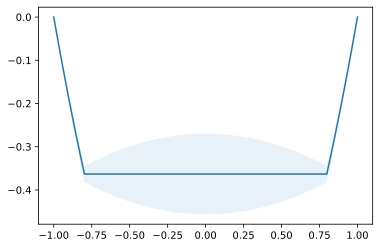

In [38]:
plt.plot(grid, u.mean)
plt.fill_between(grid, u.mean - 2 * u.var, u.mean + 2 * u.var, alpha=0.1)

In [39]:
from matplotlib import animation

def animate_bayescg_poisson_fem(**bayescg_kwargs):
    # Run the algorithm and log step statistics
    step_stats = []
    step_residual_norms = []
    step_cov_traces = []

    def _callback(x: pn.randvars.Normal, residual_norm: np.ndarray, **kwargs):
        u_mean = np.empty_like(x.mean, shape=(x.size + 2,))
        u_mean[0] = 0.0
        u_mean[1:-1] = x.mean.copy()
        u_mean[-1] = 0.0

        u_std = np.empty_like(x.mean, shape=(x.size + 2,))
        u_std[0] = 0.0
        u_std[1:-1] = np.sqrt(np.maximum(x.var, 0.0))
        u_std[-1] = 0.0

        step_stats.append((u_mean, u_std))
        step_residual_norms.append(residual_norm)
        step_cov_traces.append(np.mean(x.var))

    discrete_1d_laplace_solve_bayescg(
        grid,
        max_num_steps=N - 2,
        callback=_callback,
        **bayescg_kwargs
    )

    fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
    plt.close()

    def animate(step_idx):
        ax[0].cla()
        ax[1].cla()

        mean, std = step_stats[step_idx]

        fig.suptitle(f"1D Poisson - FEM (N = {N}) - BayesCG - Iteration {step_idx:03d}")

        ax[0].set_title("Solution")
        ax[0].set_ylim(-1.3, np.max(mean + 2 * std) + 0.1)
        ax[0].plot(grid, mean)
        ax[0].fill_between(grid, mean - 2 * std, mean + 2 * std, alpha=0.2)

        ax[1].set_title("Stopping Criteria")
        ax[1].plot(step_residual_norms[:step_idx + 1], "C0", label="residual norm")
        # ax[1].plot(step_cov_traces[:step_idx + 1], "C0", label="cov trace")
        ax[1].legend(loc="upper right")
        ax[1].set_xlabel("Iterations")

    return animation.FuncAnimation(
        fig,
        func=animate,
        frames=len(step_stats),
        interval=200,
        repeat_delay=4000,
        blit=False,
    )

In [40]:
from IPython.display import HTML

anim = animate_bayescg_poisson_fem()

HTML(anim.to_jshtml())

/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [41]:
anim.save("../results/fem_probsolve.gif", animation.PillowWriter(fps=5))

In [42]:
def discrete_1d_fourier_solve_bayescg(N: int, domain=(-1.0, 1.0), **bayescg_kwargs):
    A = discrete_1d_fourier_laplace(N, domain)
    b = discrete_1d_fourier_rhs(2.0, N, domain)
    
    return bayescg(-A, b, **bayescg_kwargs)

def coeffs_to_prob_solution(coeffs: pn.randvars.Normal, domain=(-1.0, 1.0)):
    ns = np.arange(1, coeffs.size + 1)

    def _sol(grid):
        basis = fourier_basis_element_1d(  # shape: (G, N)
            grid[:, None],
            ns[None, :],
            domain,
        )
        
        return basis @ coeffs
    
    return _sol

In [43]:
coeffs = discrete_1d_fourier_solve_bayescg(10)
sol = coeffs_to_prob_solution(coeffs)

coeffs.mean, coeffs.var

/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]))

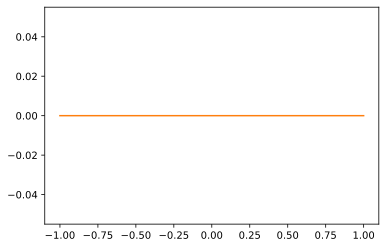

In [44]:
sol_grid = sol(grid)

plt.plot(grid, sol_grid.mean, color="C1")
plt.fill_between(grid, sol_grid.mean - 2 * sol_grid.var, sol_grid.mean + 2 * sol_grid.var, color="C0", alpha=0.1)

## Conditioning the Prior on Observations of the Solution

If we have (noisy) measurements of the solution of the PDE, we can use the information to speed up inference.

Let $(v_i)_{i = 1}^n$ be the chosen basis.
In our formulation, we posit a multivariate Gaussian prior over the coefficients $\vec{a} \in \mathbb{R}^n$ of the discretized solution $\hat{u} = \sum_{i = 1}^n a_i v_i$ to the PDE, i.e. $\vec{a} \sim \mathcal{N}(\mu_0, \Sigma_0)$.
We can relate the discretized solution $\hat{u}$ to the coefficients by a linear operator $$(\mathcal{L}_u \vec{a})(x) = \sum_{i = 1}^n a_i v_i(x).$$
Moreover, the solution can be evaluated at several locations $x_1, \dotsc, x_m \in \Omega$ by another linear operator $$(\mathcal{L}_\delta u)_j = \int_\Omega \delta(\chi - x_j) u(\chi) d \chi = u(x_j).$$
All in all, we obtain the following linear operator which maps $\vec{a}$ to a vector of measurements at $x_1, \dotsc, x_m \in \Omega$: $$(L_y \vec{a})_j = (\mathcal{L}_\delta \mathcal{L}_u \vec{a})_j = \int_\Omega \delta(\chi - x_j) (\mathcal{L}_u \vec{a})(\chi) d \chi = \sum_{i = 1}^n a_i \int_\Omega \delta(\chi - x_j) v_i(\chi) d\chi = \sum_{i = 1}^n a_i v_i(x_j)$$
If we now assume additive Gaussian measurement noise on independent observations $y_1, \dotsc, y_m$ of the solution at locations $x_1, \dotsc, x_m \in \Omega$, we obtain the following measurement likelihood:
$$p(y_1, \dots, y_m \mid u(x_1), \dotsc, u(x_m)) = \mathcal{N}(\vec{y} \mid \begin{pmatrix} u(x_1), \dotsc, u(x_m) \end{pmatrix}^T, \Lambda),$$
or, equivalently,
$$p(y_1, \dots, y_m \mid \vec{a}) = \mathcal{N}(\vec{y} \mid L_\vec{y} \vec{a}, \Lambda).$$
Since the model is linear-Gaussian, we can compute the posterior in closed form.
Note that this is exactly the supervised regression setting.

In [45]:
N = 103

grid = np.linspace(-1, 1, N)

In [46]:
# Analytic solution to the 1-d Poisson problem with constant 2.0 as rhs
ana_sol = lambda xs: xs ** 2 - 1.0

In [47]:
# Measure the solution at a grid point
meas_idcs = np.array([N // 4, N // 2, 3 * N // 4])

N_meas = meas_idcs.size

meas_xs = grid[meas_idcs]
true_ys = ana_sol(meas_xs)

# Add measurement noise
measurement_noise = pn.randvars.Normal(
    mean=np.zeros(N_meas, dtype=np.double),
    cov=pn.linops.Scaling((1e-2) ** 2, shape=N_meas, dtype=np.double),
)

meas_ys = true_ys + measurement_noise.sample()

In [48]:
meas_ys - true_ys

array([0.00977586, 0.00394515, 0.00789067])

In [49]:
# Construct the problem
A = discrete_1d_laplace_operator(grid)
b = discrete_1d_laplace_rhs(grid, 2.0)

In [50]:
# Build the prior
prior = pn.randvars.Normal(
    mean=np.zeros(N - 2, dtype=np.double),
    cov=A.inv(),
)

np.linalg.cond(prior.dense_cov)

/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/marvin/.local/miniconda3/envs/probnum/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


4215.915727603812

In [51]:
# Build the observation operator
entries = np.ones(N_meas, dtype=np.double)
row_idcs = np.arange(N_meas)
col_idcs = meas_idcs - 1  # the solution vector always excludes the boundary elements, so indices must be shifted by 1

L_yu = scipy.sparse.coo_matrix(
    (entries, (row_idcs, col_idcs)),
    shape=(N_meas, N - 2),
).tocsr()

In [52]:
# Build the noise model
noise_model = pn.randvars.Normal(
    mean=np.zeros(N_meas, dtype=np.double),
    cov=10 * measurement_noise.cov,
)

In [53]:
from typing import Union

def posterior_linear_gaussian_model(
    prior: pn.randvars.Normal,
    A: Union[np.ndarray, pn.linops.LinearOperatorLike],
    measurement_noise: pn.randvars.Normal,
    measurements: np.ndarray,
) -> pn.randvars.Normal:
    prior_x = prior
    
    if not isinstance(A, np.ndarray):
        A = pn.linops.aslinop(A)
    
    prior_pred_cov_yx = A @ prior_x.cov
    
    prior_pred_Ax = pn.randvars.Normal(
        mean=A @ prior.mean,
        cov=prior_pred_cov_yx @ A.T,
    )
    prior_pred_y = prior_pred_Ax + measurement_noise
    
    gain = scipy.linalg.cho_solve(
        scipy.linalg.cho_factor(prior_pred_y.dense_cov),
        prior_pred_cov_yx if isinstance(prior_pred_cov_yx, np.ndarray) else prior_pred_cov_yx.todense()
    ).T
    
    return pn.randvars.Normal(
        mean=prior.mean + gain @ (measurements - prior_pred_y.mean),
        cov=prior.cov - gain @ prior_pred_cov_yx
    )

In [54]:
# Condition the prior on the measurements
prior_cond_meas = posterior_linear_gaussian_model(
    prior=prior,
    A=L_yu,
    measurement_noise=noise_model,
    measurements=meas_ys,
)

np.linalg.cond(prior_cond_meas.dense_cov)

1506.5440610398466

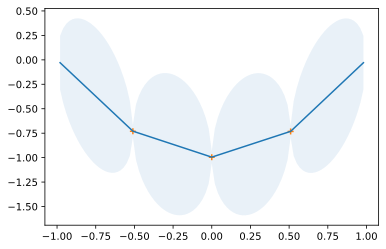

In [55]:
plt.plot(grid[1:-1], prior_cond_meas.mean)
plt.fill_between(grid[1:-1], prior_cond_meas.mean - 2 * prior_cond_meas.std, prior_cond_meas.mean + 2 * prior_cond_meas.std, alpha=0.1)
plt.scatter(meas_xs, meas_ys, marker="+")
# plt.errorbar(meas_xs, meas_ys, yerr=2 * measurement_noise.std, marker="+", linestyle="", capsize=2)

In [56]:
from IPython.display import HTML

anim = animate_bayescg_poisson_fem(prior_x=prior_cond_meas, atol=0, rtol=0)

HTML(anim.to_jshtml())

In [57]:
anim.save("../results/fem_probsolve_data.gif", animation.PillowWriter(fps=5))

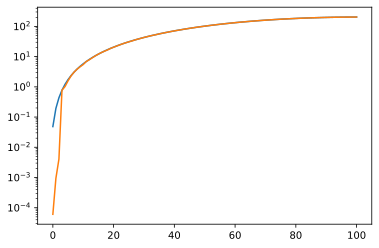

In [58]:
plt.semilogy(np.sort(A.eigvals()))
plt.semilogy(np.sort((A @ prior_cond_meas.cov @ A).eigvals()))

In [59]:
spec = np.sort((A @ prior_cond_meas.cov @ A).eigvals())
spec.min(), spec.max()

(6.049514440692177e-05, 203.90811142907532)

In [60]:
spec = np.sort(A.eigvals())
spec.min(), spec.max()

(0.048376589236645666, 203.95162341076386)